In [1]:
import pandas as pd
import pymongo
from pymongo import MongoClient
import json
import numpy as np
#from sklearn.model_selection import train_test_split
from functions import linregress

In [2]:

conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)


db = client.videos_mdb
collection = db["videos"]  

In [5]:
#Linear Machine Learning / regression (numeric variables only)

linVarList=["id","spam","commentCount", "dislikeCount","likeCount","viewCount","defaultAudioLanguage"]
df=pd.DataFrame(columns=linVarList)
row=[]
counter=0
#pull linear data from scam and non-scam categories, then sample 100 randomly from each to create training and testing data
data = collection.find({})
for item in data:
    for var in linVarList:
        if var in item:
            row.append(item[var])
        else:
            row.append(np.NAN)
    df.loc[counter] = row
    counter+=1
    row=[]

In [8]:
#Output data for SQL dataframe (unrelated project)
df.to_csv("baseLinearVars.csv", index=False)

In [7]:
df["defaultAudioLanguage"]=df["defaultAudioLanguage"].replace("en-US","US")
df["defaultAudioLanguage"]=df["defaultAudioLanguage"].replace("en-GB","GB")



In [8]:
#Create a dichotomous variable to deal with vids with disabled comments
#df['comments_enabled'] = df['commentCount'].apply(lambda x : 0 if x == "disabled" else 1)

In [9]:
#make language encoding into dummy vars
df=pd.get_dummies(df, columns = ['defaultAudioLanguage'])


In [10]:
#Create vars for like/view ratio and dislike/view ratio (possible multicovariance issues
#if we include these as well as "like" and "dislike", but we should test a few different models).
#df["likeToViews"]=df["likeCount"]/df["viewCount"]
#df["dislikeToViews"]=df["dislikeCount"]/df["viewCount"]
#df = df[df.likeCount != "."]
#df = df[df.dislikeCount != "."]
#df = df[df.viewCount != "."]
for factor in df:
    df = df[df[factor] != "."]
    try:
        df[factor]=df[factor].astype(int)
    except:
        continue
df["likeToViews"]=100*((df["likeCount"]/df["viewCount"]))
df["dislikeToViews"]=100*(df["dislikeCount"]/df["viewCount"])
df["commentToViews"]=100*(df["commentCount"]/df["viewCount"])

df=df.dropna()
df=df.drop_duplicates()


In [11]:
#df["likeToViews"]=df["likeToViews"].astype(np.float16).round(decimals = 4)

#df["dislikeToViews"]=df["dislikeToViews"].astype(np.float16).round(decimals = 4)

In [12]:
csv=df.to_csv(r'data.csv')

In [3]:
def regress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import matplotlib.pyplot as plt

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y].values.reshape(-1, 1)
    #fit the model
    model.fit(x,y)

    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Get fitstats from patsy
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    ols = sm.OLS(Y, X)
    ols_result = ols.fit()
    print(ols_result.summary())

    #Plot the Residuals
    print("\n Residual Plot")
    predictions = model.predict(x)
    for i in range(len(predictions)):
        if abs(predictions[i])>2:
            print(i)
        plt.scatter(predictions, predictions - y, color='coral',linewidths=0.5)
    plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), color='brown', linewidth=3)
    plt.show()

Optimization terminated successfully.
         Current function value: 0.446827
         Iterations 10
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                  115
Model:                          Logit   Df Residuals:                      111
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.3192
Time:                        19:21:58   Log-Likelihood:                -51.385
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 1.937e-10
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.4472      0.502     -2.881      0.004      -2.432      -0.463
likeToV

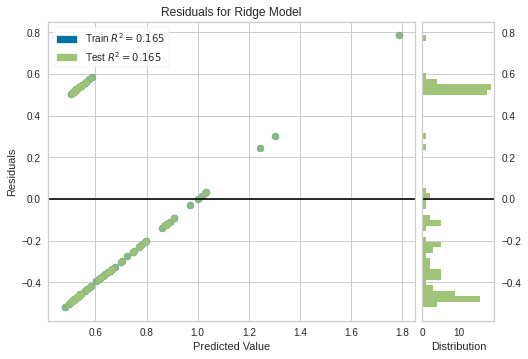

In [288]:
linregress(df,"spam","likeToViews","dislikeToViews","commentToViews")

In [13]:
df

,id,spam,commentCount,dislikeCount,likeCount,viewCount,defaultAudioLanguage_.,defaultAudioLanguage_GB,defaultAudioLanguage_US,defaultAudioLanguage_en,defaultAudioLanguage_hi,defaultAudioLanguage_it,defaultAudioLanguage_zxx,likeToViews,dislikeToViews,commentToViews
0,KH-i2P92bS4,1,421,1009,3747,93583,0,0,0,0,0,0,1,4.003932,1.078187,0.449868
1,ix1vK9-9rUw,1,466,9,329,3065,1,0,0,0,0,0,0,10.734095,0.293638,15.203915
2,UZ4OrJHDpi0,1,1147,20,511,6129,1,0,0,0,0,0,0,8.337412,0.326318,18.714309
3,6wqiOt0HO_c,1,541,20,438,5316,1,0,0,0,0,0,0,8.239278,0.376223,10.176825
4,B80XsS6uvP8,1,415,18,743,9086,1,0,0,0,0,0,0,8.177416,0.198107,4.567466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,-dBwZdc_c0M,2,4917,65,11535,375229,0,0,0,1,0,0,0,3.074123,0.017323,1.310400
123,Co0_HVab0vw,2,9455,86,10974,102265,0,0,0,1,0,0,0,10.730944,0.084095,9.245587
124,VBozk2qZEpg,2,436,23,2578,44388,0,0,0,1,0,0,0,5.807876,0.051816,0.982247
125,PC54M2M4hB0,2,262,1,451,3429,0,0,0,1,0,0,0,13.152523,0.029163,7.640712
